In [51]:
import numpy as np
import pandas as pd
from scipy import interpolate
from matplotlib import pyplot as plt


0.0043289981686965


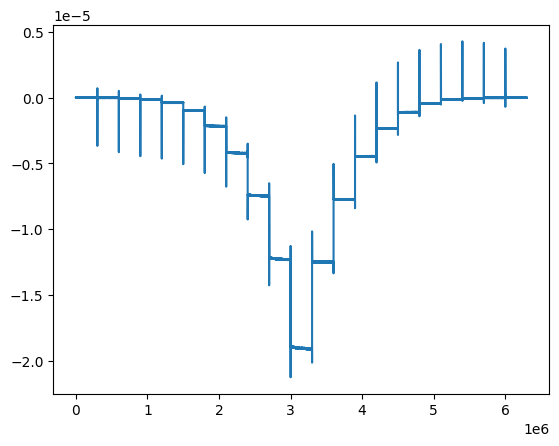

In [99]:

def load_file(file):
	bi = np.fromfile(file, dtype=np.float32)

	# Get metadata from binary file
	chMode = bi[0]
	coupling = bi[1]
	sampleRate = bi[2] 
	mode = bi[3]
	gain = bi[4]
	rSer= bi[5]
	measMode = bi[19]
	progOff=0
	length = bi[20] # length in seconds

	if measMode != 3:
		agilentOff=0
		cardOff=0
		biasDiv=0
		agilentTime=0
		rcTime=0
	else:
		agilentOff=bi[6]
		cardOff=bi[7]
		biasDiv=bi[8]
		agilentTime=bi[9]
		rcTime=bi[10]

	# filename from input
	fileName = file.split("/")[-1]

	# Number of segments influencing the data [metadata(22) -> segment(numOfSegments*3) -> data(remaining)]
	numOfSegments = int(bi[21])
	

	# Segment data -> [length, start, end]
	endOfSegmentsIndex = 22 + (numOfSegments * 3)
	segmentArray = bi[22:endOfSegmentsIndex].reshape(numOfSegments,3).T

	# Data is (V)
	rawData = bi[endOfSegmentsIndex:]

	# this snippet is used to generate the arbitrary signal for the fixed length of 65535
	# i know it looks magic, sry for that
	# what it does is first generate a signal for the fixed length of 65535 and then scales back it according to the length of the rawData
	# commented arbSignalFixed can help with understanding
	# this signal is in (V)

	cons = 65535
	rLen = len(rawData)
	#arbSignalFixed = np.zeros(cons) 
	arbSignalFull = np.zeros(rLen) 
	start = 0
	for i in range(numOfSegments):
		next = i < numOfSegments-1 and int(segmentArray[0][i+1]) or cons
		#arbSignalFixed[start:next] = np.linspace(segmentArray[1][i], segmentArray[2][i], next-start)
		scaledStart, scaledNext = int(rLen*(start/cons)), int(rLen*(next/cons))
		arbSignalFull[scaledStart:scaledNext] = np.linspace(segmentArray[1][i], segmentArray[2][i], scaledNext-scaledStart)
		start = next

	# this signal needs to be converted to the length of the rawData
	
	rawData = rawData/gain
	if mode == 0:
		resistance = (rawData*rSer)/(arbSignalFull-rawData)
	elif mode == 1:
		resistance = arbSignalFull/(rawData-rSer)
	print(resistance.mean())
	plt.plot(rawData)
load_file("_old/test1_seg")